### Training LeNet with MNIST

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms,datasets
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision

import copy
import time

In [2]:
apply_transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor()])
BatchSize = 100

trainset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = datasets.MNIST(root='./MNIST', train=False, download=True, transform=apply_transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

In [3]:
# Size of train and test datasets
print('No. of samples in train set: '+str(len(trainLoader.dataset)))
print('No. of samples in test set: '+str(len(testLoader.dataset)))

No. of samples in train set: 60000
No. of samples in test set: 10000


### LeNet Architecture

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

In [5]:
net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
# Copying initial weights for visualization
init_weightConv1 = copy.deepcopy(net.conv1.weight.data)
init_weightConv2 = copy.deepcopy(net.conv2.weight.data)

In [7]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')   
    net = net.cuda()

GPU is available!


### Define Loss and Optimizer

In [8]:
criterion = nn.NLLLoss() # Negative Log-likelihood
optimizer = optim.Adam(net.parameters(), lr=1e-4) # Adam

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 1 /10  ;  Training Loss: 0.010447 ; Testing Acc: 87.550 ; Time consumed: 0m 7s 
Iteration: 2 /10  ;  Training Loss: 0.003597 ; Testing Acc: 91.180 ; Time consumed: 0m 5s 
Iteration: 3 /10  ;  Training Loss: 0.002703 ; Testing Acc: 93.060 ; Time consumed: 0m 5s 
Iteration: 4 /10  ;  Training Loss: 0.002219 ; Testing Acc: 94.510 ; Time consumed: 0m 5s 
Iteration: 5 /10  ;  Training Loss: 0.001868 ; Testing Acc: 95.260 ; Time consumed: 0m 5s 
Iteration: 6 /10  ;  Training Loss: 0.001622 ; Testing Acc: 96.100 ; Time consumed: 0m 5s 
Iteration: 7 /10  ;  Training Loss: 0.001424 ; Testing Acc: 96.430 ; Time consumed: 0m 5s 
Iteration: 8 /10  ;  Training Loss: 0.001267 ; Testing Acc: 96.710 ; Time consumed: 0m 5s 
Iteration: 9 /10  ;  Training Loss: 0.001149 ; Testing Acc: 97.020 ; Time consumed: 0m 5s 
Iteration: 10 /10  ;  Training Loss: 0.001057 ; Testing Acc: 97.290 ; Time consumed: 0m 5s 
Training completed in 0m 51s


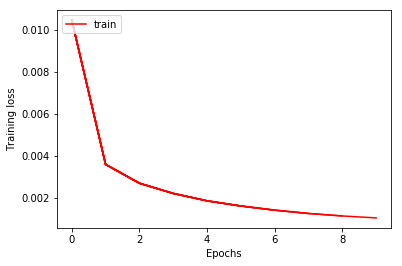

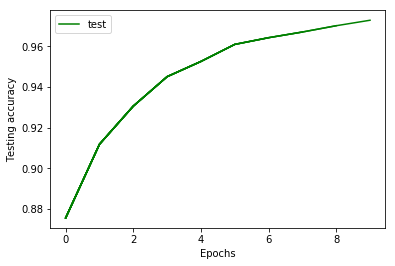

In [9]:
iterations = 10
trainLoss = []
testAcc = []
start = time.time()
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0    
    net.train(True) # For training
    for data in trainLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)  
       
        # Initialize gradients to zero
        optimizer.zero_grad()
        # Feed-forward input data through the network        
        outputs = net(inputs)        
        # Compute loss/error
        loss = criterion(outputs, labels)
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.data[0]    
    avgTrainLoss = runningLoss/60000.0
    trainLoss.append(avgTrainLoss)
    
    # Evaluating performance on test set for each epoch
    net.train(False) # For testing [Affects batch-norm and dropout layers (if any)]
    running_correct = 0
    for data in testLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs = Variable(inputs.cuda())
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu()
        else:
            inputs = Variable(inputs)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum()
    avgTestAcc = running_correct/10000.0
    testAcc.append(avgTestAcc)
        
    # Plotting training loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r-',label='train')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Training loss')   
    # Plotting testing accuracy vs Epochs
    fig2 = plt.figure(2)        
    plt.plot(range(epoch+1),testAcc,'g-',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Testing accuracy')    
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,avgTestAcc*100,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))

In [10]:
# Copying trained weights for visualization
trained_weightConv1 = copy.deepcopy(net.conv1.weight.data)
trained_weightConv2 = copy.deepcopy(net.conv2.weight.data)

### Weight Visualization

In [11]:
# functions to show an image
def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

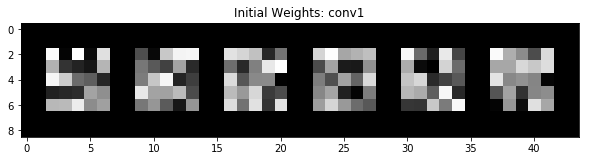

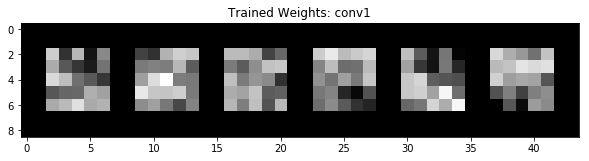

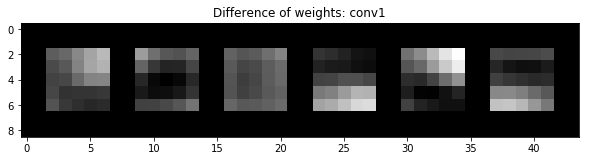

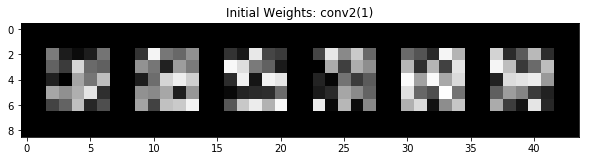

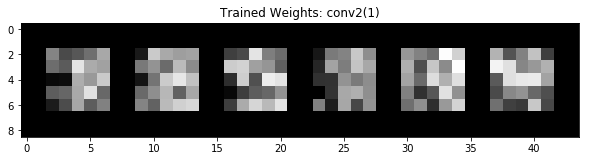

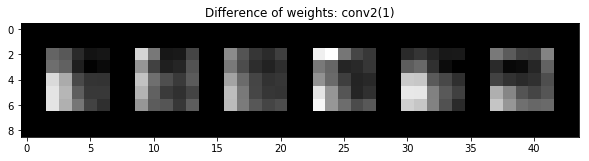

In [12]:
imshow(torchvision.utils.make_grid(init_weightConv1,nrow=6,normalize=True),'Initial Weights: conv1')
imshow(torchvision.utils.make_grid(trained_weightConv1.cpu(),nrow=6,normalize=True),'Trained Weights: conv1')
imshow(torchvision.utils.make_grid(init_weightConv1-trained_weightConv1.cpu(),nrow=6,normalize=True),'Difference of weights: conv1')

imshow(torchvision.utils.make_grid(init_weightConv2[0].unsqueeze(1),nrow=6,normalize=True),'Initial Weights: conv2(1)')
imshow(torchvision.utils.make_grid(trained_weightConv2[0].unsqueeze(1).cpu(),nrow=6,normalize=True),'Trained Weights: conv2(1)')
imshow(torchvision.utils.make_grid(init_weightConv2[0].unsqueeze(1)-trained_weightConv2[0].unsqueeze(1).cpu(),nrow=6,normalize=True),'Difference of weights: conv2(1)')